# Predicting Subreddit Pages: Nike or Adidas?

Prepared by: Jessie Owens

## Executive Summary

- [Problem Statement](#Problem_Statement)
- [Description of Data](#Description_of_Data)
- [Import Libraries](#Import_Libraries)
- [EDA](#EDA)
- [Modeling](#Modeling)
- [Conclusions & Next Steps](#Conclusions_&_Next_Steps)
- [Sources](#Sources)

## Problem Statement

Does marketing language influence online conversations about products? I was curious about two things:
1. If you remove the brand name and product names from the text, can we predict the brand that an online post is discussing using an NLP model? 
2. How does the language that is used in a marketing campaign influence the way a brand’s critics and supporters choose to talk about that brand in an online setting? 


## Description of Data

The data included in this analysis was pulled from https://www.reddit.com and includes posts from two subreddit pages:
- /r/Nike
- /r/adidas

The data collection process was completed in another [Jupyter Notebook](./reddit_data_collection.ipynb).

There were 4120 total posts pulled from the two subreddit pages, including 1992 from the Nike subreddit and 2128 from the Adidas subreddit. The posts are from December 20, 2018 to October 15, 2019. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from bs4 import BeautifulSoup             
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jessieowens2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessieowens2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EDA

In [2]:
# read in the brands data compiled in a sparate JN
brands = pd.read_csv('./data/brands.csv')

In [3]:
brands.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,Are womens sizes the same as mens for Nike M2K...,There is a particular colour of Nike M2K train...,Nike,1568401703,johnnyredneat,1,0,True,2019-09-13
1,1,Laces,What kind of laces does the FoG Raid comes wit...,Nike,1568406910,Hoxton_0451,0,0,True,2019-09-13
2,2,Sizing question on buying men’s for women. Siz...,Soo I had been eyeing the women’s Nike Air Max...,Nike,1568443108,buzzbuzzbih,3,0,True,2019-09-14
3,3,Trying to remember a hoodie or shirt Drake wore,i remember seeing pictures of drake wearing a ...,Nike,1568486842,perpetualpies,3,0,True,2019-09-14
4,4,Thankyou to my Nike tanjuns,http://imgur.com/a/uVOw8g8\n\nThey lasted me s...,Nike,1568497739,adeptwarrior,0,0,True,2019-09-14


In [4]:
brands.shape

(4120, 10)

In [5]:
brands['subreddit'].value_counts()

adidas    2128
Nike      1992
Name: subreddit, dtype: int64

In [6]:
brands.tail()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
4115,12,Nike Promo Codes?,Does anyone have any online Nike promo codes? ...,Nike,1562776770,titi321,2,0,True,2019-07-10
4116,0,Best Nikes for standing all day?,NaN,Nike,1562636033,parksandtheoffice,2,1,True,2019-07-08
4117,5,"Stranger things drop at 8am, is that west coas...",Title,Nike,1562659979,xColaDoo,1,0,True,2019-07-09
4118,12,ID on these Nike high tops,&amp;#x200B;\n\nhttps://i.redd.it/p0f1ju1z6b93...,Nike,1562691617,GuyNamedNoah,0,1,True,2019-07-09
4119,16,Trying to find a Nike ad,Saw a Nike ad (few weeks back I think?) Where ...,Nike,1562699201,TopNotchGamerr,0,1,True,2019-07-09


In [7]:
brands.isnull().sum()

Unnamed: 0        0
title             0
selftext        360
subreddit         0
created_utc       0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
dtype: int64

In [8]:
brands.dropna(inplace=True)

In [124]:
brands.shape

(3760, 13)

In [125]:
brands['subreddit'].value_counts()

adidas    1953
Nike      1807
Name: subreddit, dtype: int64

In [126]:
brands['subreddit'].value_counts(normalize=True)

adidas    0.519415
Nike      0.480585
Name: subreddit, dtype: float64

In [10]:
brands.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
brands.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Are womens sizes the same as mens for Nike M2K...,There is a particular colour of Nike M2K train...,Nike,1568401703,johnnyredneat,1,0,True,2019-09-13
1,Laces,What kind of laces does the FoG Raid comes wit...,Nike,1568406910,Hoxton_0451,0,0,True,2019-09-13
2,Sizing question on buying men’s for women. Siz...,Soo I had been eyeing the women’s Nike Air Max...,Nike,1568443108,buzzbuzzbih,3,0,True,2019-09-14
3,Trying to remember a hoodie or shirt Drake wore,i remember seeing pictures of drake wearing a ...,Nike,1568486842,perpetualpies,3,0,True,2019-09-14
4,Thankyou to my Nike tanjuns,http://imgur.com/a/uVOw8g8\n\nThey lasted me s...,Nike,1568497739,adeptwarrior,0,0,True,2019-09-14


In [12]:
# drop author
# brands.drop('author', axis=1, inplace=True)

In [13]:
brands['selftext'][800]

'Does anyone know how big the huarache drift air unit is or how does it look like?'

In [14]:
# not doing any HTML cleaning because seems to not be necessary

In [15]:
cleaned_brands = brands

In [16]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"%", "percent")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\_\\n]", " ")
#     df[text_field] = df[text_field].str.replace(r"\\n", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
#     df[text_field] = df[text_field].str.replace(r"13 5", "thirteenhalf")
#     df[text_field] = df[text_field].str.replace(r"14", "fourteen")
#     df[text_field] = df[text_field].str.replace(r"11", "eleven")
    df[text_field] = df[text_field].str.lower()
    return df

# got this function from Emmanuel Ameisen's blog post on NLP: 
# https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e

In [17]:
standardize_text(cleaned_brands, 'selftext')

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Are womens sizes the same as mens for Nike M2K...,there is a particular colour of nike m2k train...,Nike,1568401703,johnnyredneat,1,0,True,2019-09-13
1,Laces,what kind of laces does the fog raid comes wit...,Nike,1568406910,Hoxton_0451,0,0,True,2019-09-13
2,Sizing question on buying men’s for women. Siz...,soo i had been eyeing the women s nike air max...,Nike,1568443108,buzzbuzzbih,3,0,True,2019-09-14
3,Trying to remember a hoodie or shirt Drake wore,i remember seeing pictures of drake wearing a ...,Nike,1568486842,perpetualpies,3,0,True,2019-09-14
4,Thankyou to my Nike tanjuns,they lasted me since 2015 5 years service a...,Nike,1568497739,adeptwarrior,0,0,True,2019-09-14
...,...,...,...,...,...,...,...,...,...
4114,Where can I find these Jordan basketball short...,not sure what these are called or if it s even...,Nike,1562757768,Curious_George_Asks,0,2,True,2019-07-10
4115,Nike Promo Codes?,does anyone have any online nike promo codes? ...,Nike,1562776770,titi321,2,0,True,2019-07-10
4117,"Stranger things drop at 8am, is that west coas...",title,Nike,1562659979,xColaDoo,1,0,True,2019-07-09
4118,ID on these Nike high tops,amp x200b,Nike,1562691617,GuyNamedNoah,0,1,True,2019-07-09


In [18]:
standardize_text(cleaned_brands, 'title')

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,are womens sizes the same as mens for nike m2k...,there is a particular colour of nike m2k train...,Nike,1568401703,johnnyredneat,1,0,True,2019-09-13
1,laces,what kind of laces does the fog raid comes wit...,Nike,1568406910,Hoxton_0451,0,0,True,2019-09-13
2,sizing question on buying men s for women siz...,soo i had been eyeing the women s nike air max...,Nike,1568443108,buzzbuzzbih,3,0,True,2019-09-14
3,trying to remember a hoodie or shirt drake wore,i remember seeing pictures of drake wearing a ...,Nike,1568486842,perpetualpies,3,0,True,2019-09-14
4,thankyou to my nike tanjuns,they lasted me since 2015 5 years service a...,Nike,1568497739,adeptwarrior,0,0,True,2019-09-14
...,...,...,...,...,...,...,...,...,...
4114,where can i find these jordan basketball short...,not sure what these are called or if it s even...,Nike,1562757768,Curious_George_Asks,0,2,True,2019-07-10
4115,nike promo codes?,does anyone have any online nike promo codes? ...,Nike,1562776770,titi321,2,0,True,2019-07-10
4117,"stranger things drop at 8am, is that west coas...",title,Nike,1562659979,xColaDoo,1,0,True,2019-07-09
4118,id on these nike high tops,amp x200b,Nike,1562691617,GuyNamedNoah,0,1,True,2019-07-09


In [19]:
# STOPWORDS??
#     # 4. In Python, searching a set is much faster than searching
#     # a list, so convert the stop words to a set.
#     stops = set(stopwords.words('english'))
    
#     # 5. Remove stop words.
#     meaningful_words = [w for w in words if w not in stops]

In [20]:
# Get the number of posts based on the dataframe size.
total_posts = cleaned_brands.shape[0]
print(f'There are {total_posts} posts.')

There are 3760 posts.


In [21]:
cleaned_brands.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,are womens sizes the same as mens for nike m2k...,there is a particular colour of nike m2k train...,Nike,1568401703,johnnyredneat,1,0,True,2019-09-13
1,laces,what kind of laces does the fog raid comes wit...,Nike,1568406910,Hoxton_0451,0,0,True,2019-09-13
2,sizing question on buying men s for women siz...,soo i had been eyeing the women s nike air max...,Nike,1568443108,buzzbuzzbih,3,0,True,2019-09-14
3,trying to remember a hoodie or shirt drake wore,i remember seeing pictures of drake wearing a ...,Nike,1568486842,perpetualpies,3,0,True,2019-09-14
4,thankyou to my nike tanjuns,they lasted me since 2015 5 years service a...,Nike,1568497739,adeptwarrior,0,0,True,2019-09-14


In [22]:
tokenizer = RegexpTokenizer(r'\w+')

In [23]:
cleaned_brands['title_tokens'] = cleaned_brands['title'].apply(tokenizer.tokenize)

In [24]:
cleaned_brands.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,title_tokens
0,are womens sizes the same as mens for nike m2k...,there is a particular colour of nike m2k train...,Nike,1568401703,johnnyredneat,1,0,True,2019-09-13,"[are, womens, sizes, the, same, as, mens, for,..."
1,laces,what kind of laces does the fog raid comes wit...,Nike,1568406910,Hoxton_0451,0,0,True,2019-09-13,[laces]
2,sizing question on buying men s for women siz...,soo i had been eyeing the women s nike air max...,Nike,1568443108,buzzbuzzbih,3,0,True,2019-09-14,"[sizing, question, on, buying, men, s, for, wo..."
3,trying to remember a hoodie or shirt drake wore,i remember seeing pictures of drake wearing a ...,Nike,1568486842,perpetualpies,3,0,True,2019-09-14,"[trying, to, remember, a, hoodie, or, shirt, d..."
4,thankyou to my nike tanjuns,they lasted me since 2015 5 years service a...,Nike,1568497739,adeptwarrior,0,0,True,2019-09-14,"[thankyou, to, my, nike, tanjuns]"


In [25]:
cleaned_brands['text_tokens'] = cleaned_brands['selftext'].apply(tokenizer.tokenize)

In [26]:
cleaned_brands.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,title_tokens,text_tokens
0,are womens sizes the same as mens for nike m2k...,there is a particular colour of nike m2k train...,Nike,1568401703,johnnyredneat,1,0,True,2019-09-13,"[are, womens, sizes, the, same, as, mens, for,...","[there, is, a, particular, colour, of, nike, m..."
1,laces,what kind of laces does the fog raid comes wit...,Nike,1568406910,Hoxton_0451,0,0,True,2019-09-13,[laces],"[what, kind, of, laces, does, the, fog, raid, ..."
2,sizing question on buying men s for women siz...,soo i had been eyeing the women s nike air max...,Nike,1568443108,buzzbuzzbih,3,0,True,2019-09-14,"[sizing, question, on, buying, men, s, for, wo...","[soo, i, had, been, eyeing, the, women, s, nik..."
3,trying to remember a hoodie or shirt drake wore,i remember seeing pictures of drake wearing a ...,Nike,1568486842,perpetualpies,3,0,True,2019-09-14,"[trying, to, remember, a, hoodie, or, shirt, d...","[i, remember, seeing, pictures, of, drake, wea..."
4,thankyou to my nike tanjuns,they lasted me since 2015 5 years service a...,Nike,1568497739,adeptwarrior,0,0,True,2019-09-14,"[thankyou, to, my, nike, tanjuns]","[they, lasted, me, since, 2015, 5, years, serv..."


In [27]:
cleaned_brands['total_tokens'] = cleaned_brands['title_tokens'] + cleaned_brands['text_tokens']

In [28]:
all_words = [word for tokens in cleaned_brands["total_tokens"] for word in tokens]
post_lengths = [len(tokens) for tokens in cleaned_brands["total_tokens"]]
VOCAB = sorted(list(set(all_words)))
print(f"{len(all_words)} words total, with a vocabulary size of {len(VOCAB)}")
print(f"Max post length is {max(post_lengths)}")

215778 words total, with a vocabulary size of 8410
Max post length is 2645


In [29]:
len(all_words)

215778

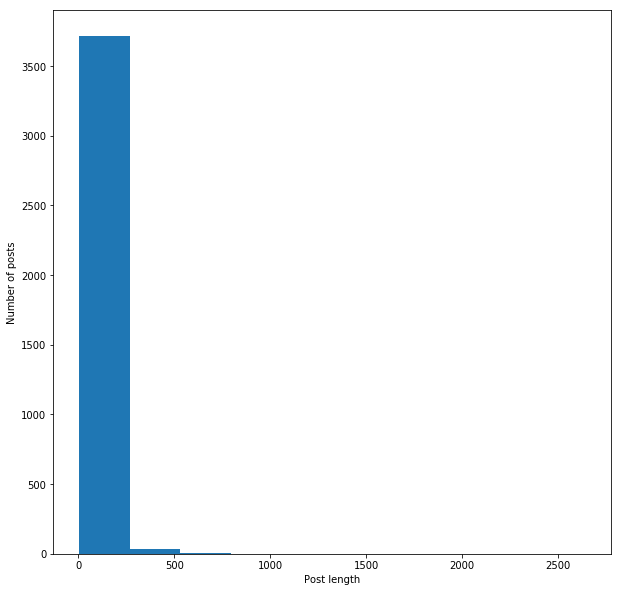

In [30]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Post length')
plt.ylabel('Number of posts')
plt.hist(post_lengths)
plt.show()

In [31]:
# tokenize self text

In [32]:
# tokenize title as well? or redundant of selftext

In [33]:
# remove any image/video references

In [34]:
# determine which columns to remove that have brand identifiers (brand name or product name)

In [35]:
cleaned_brands['total_text'] = cleaned_brands['title'] + ' ' + cleaned_brands['selftext']

In [36]:
cleaned_brands.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,title_tokens,text_tokens,total_tokens,total_text
0,are womens sizes the same as mens for nike m2k...,there is a particular colour of nike m2k train...,Nike,1568401703,johnnyredneat,1,0,True,2019-09-13,"[are, womens, sizes, the, same, as, mens, for,...","[there, is, a, particular, colour, of, nike, m...","[are, womens, sizes, the, same, as, mens, for,...",are womens sizes the same as mens for nike m2k...
1,laces,what kind of laces does the fog raid comes wit...,Nike,1568406910,Hoxton_0451,0,0,True,2019-09-13,[laces],"[what, kind, of, laces, does, the, fog, raid, ...","[laces, what, kind, of, laces, does, the, fog,...",laces what kind of laces does the fog raid com...
2,sizing question on buying men s for women siz...,soo i had been eyeing the women s nike air max...,Nike,1568443108,buzzbuzzbih,3,0,True,2019-09-14,"[sizing, question, on, buying, men, s, for, wo...","[soo, i, had, been, eyeing, the, women, s, nik...","[sizing, question, on, buying, men, s, for, wo...",sizing question on buying men s for women siz...
3,trying to remember a hoodie or shirt drake wore,i remember seeing pictures of drake wearing a ...,Nike,1568486842,perpetualpies,3,0,True,2019-09-14,"[trying, to, remember, a, hoodie, or, shirt, d...","[i, remember, seeing, pictures, of, drake, wea...","[trying, to, remember, a, hoodie, or, shirt, d...",trying to remember a hoodie or shirt drake wor...
4,thankyou to my nike tanjuns,they lasted me since 2015 5 years service a...,Nike,1568497739,adeptwarrior,0,0,True,2019-09-14,"[thankyou, to, my, nike, tanjuns]","[they, lasted, me, since, 2015, 5, years, serv...","[thankyou, to, my, nike, tanjuns, they, lasted...",thankyou to my nike tanjuns they lasted me s...


In [37]:
cleaned_brands.shape

(3760, 13)

## Modeling

In [38]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_brands[['total_text']], 
                                                    cleaned_brands['subreddit'], 
                                                    test_size=.30, 
                                                    random_state=42)

In [39]:
# Converting the posts to a list of strings
clean_train_posts = []
clean_test_posts = []

for train_post in X_train['total_text']:
    clean_train_posts.append(train_post)
    
for test_post in X_test['total_text']:
    clean_test_posts.append(test_post)

In [40]:
X_train = clean_train_posts
X_test = clean_test_posts

In [41]:
# instantiate lists for creating a dataframe of models, scores later on
models = []
transformers = []
stop_words = []
train_scores = []
test_scores = []
params = []

In [42]:
# MODEL 1: cvec, logreg, no stop words
pipe = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression())])

pipe_params = {'cvec__max_features': [500, 1000, 1500], 
               'cvec__min_df': [2, 3], 
               'cvec__max_df': [0.9, 0.95], 
               'cvec__ngram_range': [(1, 1), (1, 2)]}

gs = GridSearchCV(pipe, pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

0.9000759878419453


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [43]:
gs_model = gs.best_estimator_

In [44]:
pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

In [45]:
pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

In [46]:
models.append('Logistic_reg')

transformers.append('cvec')

stop_words.append('none')

params.append(gs.best_params_)

In [47]:
# check lists
print(f"Model: {models}")
print(f"Transformer: {transformers}")
print(f"Params: {params}")
print(f"Stop words: {stop_words}")
print(f"Train score: {train_scores}")
print(f"Test scores: {test_scores}")

Model: ['Logistic_reg']
Transformer: ['cvec']
Params: [{'cvec__max_df': 0.9, 'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}]
Stop words: ['none']
Train score: [0.9912613981762918]
Test scores: [0.9193262411347518]


In [48]:
# MODEL 2: cvec, svc, no stop words
pipe_2 = Pipeline([('cvec', CountVectorizer()), ('svc', SVC())])


pipe_2_params = {'cvec__max_features': [500, 1000, 1500], 
                 'cvec__min_df': [2, 3], 
                 'cvec__max_df': [0.9, 0.95], 
                 'cvec__ngram_range': [(1, 1), (1, 2)],
                 'svc__C': [1.0, 0.75, 0.5, 0.25], 
                 'svc__kernel': ['rbf', 'poly', 'linear'], 
                 'svc__gamma': ['scale']
                }

gs = GridSearchCV(pipe_2, pipe_2_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8894376899696048


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'svc__C': 0.25,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear'}

In [49]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('SVC')

transformers.append('cvec')

stop_words.append('none')

params.append(gs.best_params_)

In [50]:
# MODEL 3: cvec, svc, English stop words
pipe_3 = Pipeline([('cvec', CountVectorizer()), ('svc', SVC())])


pipe_3_params = {'cvec__max_features': [500, 1000, 1500], 
                 'cvec__min_df': [2, 3], 
                 'cvec__max_df': [0.9, 0.95], 
                 'cvec__ngram_range': [(1, 1), (1, 2)], 
                 'cvec__stop_words': ['english'],
                 'svc__C': [1.0, 0.75, 0.5, 0.25], 
                 'svc__kernel': ['rbf', 'poly', 'linear'], 
                 'svc__gamma': ['scale']
                }

gs = GridSearchCV(pipe_3, pipe_3_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9008358662613982


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'svc__C': 0.25,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear'}

In [51]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('SVC')

transformers.append('cvec')

stop_words.append('English')

params.append(gs.best_params_)

In [52]:
# MODEL 4: cvec, svc, brand stop words
pipe_4 = Pipeline([('cvec', CountVectorizer()), ('svc', SVC())])


pipe_4_params = {'cvec__max_features': [500, 1000, 1500], 
                 'cvec__min_df': [2, 3], 
                 'cvec__max_df': [0.9, 0.95], 
                 'cvec__ngram_range': [(1, 1), (1, 2)], 
                 'cvec__stop_words': [('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS')],
                 'svc__C': [1.0, 0.75, 0.5, 0.25], 
                 'svc__kernel': ['rbf', 'poly', 'linear'], 
                 'svc__gamma': ['scale']
                }

gs = GridSearchCV(pipe_4, pipe_4_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8031914893617021


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS'),
 'svc__C': 1.0,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear'}

In [53]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('SVC')

transformers.append('cvec')

stop_words.append('Brand names')

params.append(gs.best_params_)

In [54]:
# MODEL 5: cvec, naive bayes, none stop words
pipe_5 = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])

pipe_5_params = {'cvec__max_features': [500, 1000, 1500], 
                 'cvec__min_df': [2, 3], 
                 'cvec__max_df': [0.9, 0.95], 
                 'cvec__ngram_range': [(1, 1), (1, 2)], 
                 'cvec__stop_words': [None],
                 'mnb__alpha': [1.0, 0.75, 0.5, 0.25], 
                 'mnb__fit_prior': [True, False]
                }

gs = GridSearchCV(pipe_5, pipe_5_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.895516717325228


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'mnb__alpha': 0.75,
 'mnb__fit_prior': False}

In [55]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('Naive Bayes (MNB)')

transformers.append('cvec')

stop_words.append('none')

params.append(gs.best_params_)

In [56]:
# MODEL 6: cvec, naive bayes, English stop words
pipe_6 = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])

pipe_6_params = {'cvec__max_features': [500, 1000, 1500], 
                 'cvec__min_df': [2, 3], 
                 'cvec__max_df': [0.9, 0.95], 
                 'cvec__ngram_range': [(1, 1), (1, 2)], 
                 'cvec__stop_words': ['english'],
                 'mnb__alpha': [1.0, 0.75, 0.5, 0.25], 
                 'mnb__fit_prior': [True, False]
                }

gs = GridSearchCV(pipe_6, pipe_6_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9057750759878419


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'mnb__alpha': 0.25,
 'mnb__fit_prior': False}

In [57]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('Naive Bayes (MNB)')

transformers.append('cvec')

stop_words.append('English')

params.append(gs.best_params_)

In [58]:
# MODEL 7: cvec, naive bayes, brand stop words
pipe_7 = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])

pipe_7_params = {'cvec__max_features': [500, 1000, 1500], 
                 'cvec__min_df': [2, 3], 
                 'cvec__max_df': [0.9, 0.95], 
                 'cvec__ngram_range': [(1, 1), (1, 2)], 
                 'cvec__stop_words': [('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS')],
                 'mnb__alpha': [1.0, 0.75, 0.5, 0.25], 
                 'mnb__fit_prior': [True, False]
                }

gs = GridSearchCV(pipe_7, pipe_7_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8104103343465046


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS'),
 'mnb__alpha': 0.25,
 'mnb__fit_prior': False}

In [59]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('Naive Bayes (MNB)')

transformers.append('cvec')

stop_words.append('Brand names')

params.append(gs.best_params_)

In [60]:
# MODEL 8: tfidf, svc, no stop words
pipe_8 = Pipeline([('tifdif', TfidfVectorizer()), ('svc', SVC())])

pipe_8_params = {'tifdif__max_features': [500, 1000, 1500], 
                 'tifdif__min_df': [2, 3], 
                 'tifdif__max_df': [0.9, 0.95], 
                 'tifdif__ngram_range': [(1, 1), (1, 2)], 
                 'tifdif__stop_words': [None],
                 'svc__C': [1.0, 0.75, 0.5, 0.25], 
                 'svc__kernel': ['rbf', 'poly', 'linear'], 
                 'svc__gamma': ['scale']
                }

gs = GridSearchCV(pipe_8, pipe_8_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9110942249240122


{'svc__C': 1.0,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'tifdif__max_df': 0.9,
 'tifdif__max_features': 1500,
 'tifdif__min_df': 2,
 'tifdif__ngram_range': (1, 2),
 'tifdif__stop_words': None}

In [61]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('SVC')

transformers.append('tfidf')

stop_words.append('none')

params.append(gs.best_params_)

In [62]:
# MODEL 9: tfidf, svc, English stop words
pipe_9 = Pipeline([('tifdif', TfidfVectorizer()), ('svc', SVC())])

pipe_9_params = {'tifdif__max_features': [500, 1000, 1500], 
                 'tifdif__min_df': [2, 3], 
                 'tifdif__max_df': [0.9, 0.95], 
                 'tifdif__ngram_range': [(1, 1), (1, 2)], 
                 'tifdif__stop_words': ['english'],
                 'svc__C': [1.0, 0.75, 0.5, 0.25], 
                 'svc__kernel': ['rbf', 'poly', 'linear'], 
                 'svc__gamma': ['scale']
                }

gs = GridSearchCV(pipe_9, pipe_9_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.918693009118541


{'svc__C': 1.0,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'tifdif__max_df': 0.9,
 'tifdif__max_features': 1500,
 'tifdif__min_df': 2,
 'tifdif__ngram_range': (1, 2),
 'tifdif__stop_words': 'english'}

In [63]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('SVC')

transformers.append('tfidf')

stop_words.append('English')

params.append(gs.best_params_)

In [67]:
# MODEL 10: tfidf, svc, brand stop words
pipe_10 = Pipeline([('tifdif', TfidfVectorizer()), ('svc', SVC())])

pipe_10_params = {'tifdif__max_features': [500, 1000, 1500], 
                 'tifdif__min_df': [2, 3], 
                 'tifdif__max_df': [0.9, 0.95], 
                 'tifdif__ngram_range': [(1, 1), (1, 2)], 
                 'tifdif__stop_words': [('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS')],
                 'svc__C': [1.0, 0.75, 0.5, 0.25], 
                 'svc__kernel': ['rbf', 'poly', 'linear'], 
                 'svc__gamma': ['scale']
                }

gs = GridSearchCV(pipe_10, pipe_10_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8164893617021277


{'svc__C': 1.0,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'tifdif__max_df': 0.9,
 'tifdif__max_features': 1500,
 'tifdif__min_df': 3,
 'tifdif__ngram_range': (1, 1),
 'tifdif__stop_words': ('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS')}

In [68]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('SVC')

transformers.append('tfidf')

stop_words.append('Brand names')

params.append(gs.best_params_)

In [69]:
# MODEL 11: tfidf, naive bayes, no stop words
pipe_11 = Pipeline([('tifdif', TfidfVectorizer()), ('mnb', MultinomialNB())])

pipe_11_params = {'tifdif__max_features': [500, 1000, 1500], 
                 'tifdif__min_df': [2, 3], 
                 'tifdif__max_df': [0.9, 0.95], 
                 'tifdif__ngram_range': [(1, 1), (1, 2)], 
                 'tifdif__stop_words': [None],
                 'mnb__alpha': [1.0, 0.75, 0.5, 0.25], 
                 'mnb__fit_prior': [True, False]
                }

gs = GridSearchCV(pipe_11, pipe_11_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8863981762917933


{'mnb__alpha': 1.0,
 'mnb__fit_prior': False,
 'tifdif__max_df': 0.9,
 'tifdif__max_features': 1500,
 'tifdif__min_df': 2,
 'tifdif__ngram_range': (1, 1),
 'tifdif__stop_words': None}

In [70]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('Naive Bayes (MNB)')

transformers.append('tfidf')

stop_words.append('none')

params.append(gs.best_params_)

In [71]:
# MODEL 12: tfidf, naive bayes, English stop words
pipe_12 = Pipeline([('tifdif', TfidfVectorizer()), ('mnb', MultinomialNB())])

pipe_12_params = {'tifdif__max_features': [500, 1000, 1500], 
                 'tifdif__min_df': [2, 3], 
                 'tifdif__max_df': [0.9, 0.95], 
                 'tifdif__ngram_range': [(1, 1), (1, 2)], 
                 'tifdif__stop_words': ['english'],
                 'mnb__alpha': [1.0, 0.75, 0.5, 0.25], 
                 'mnb__fit_prior': [True, False]
                }

gs = GridSearchCV(pipe_12, pipe_12_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8947568389057751


{'mnb__alpha': 1.0,
 'mnb__fit_prior': False,
 'tifdif__max_df': 0.9,
 'tifdif__max_features': 1500,
 'tifdif__min_df': 2,
 'tifdif__ngram_range': (1, 1),
 'tifdif__stop_words': 'english'}

In [72]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('Naive Bayes (MNB)')

transformers.append('tfidf')

stop_words.append('English')

params.append(gs.best_params_)

In [73]:
# MODEL 13: tfidf, naive bayes, brand stop words
pipe_13 = Pipeline([('tifdif', TfidfVectorizer()), ('mnb', MultinomialNB())])

pipe_13_params = {'tifdif__max_features': [500, 1000, 1500], 
                 'tifdif__min_df': [2, 3], 
                 'tifdif__max_df': [0.9, 0.95], 
                 'tifdif__ngram_range': [(1, 1), (1, 2)], 
                 'tifdif__stop_words': [('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS')],
                 'mnb__alpha': [1.0, 0.75, 0.5, 0.25], 
                 'mnb__fit_prior': [True, False]
                }

gs = GridSearchCV(pipe_13, pipe_13_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8111702127659575


{'mnb__alpha': 0.25,
 'mnb__fit_prior': False,
 'tifdif__max_df': 0.9,
 'tifdif__max_features': 1500,
 'tifdif__min_df': 3,
 'tifdif__ngram_range': (1, 1),
 'tifdif__stop_words': ('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS')}

In [74]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('Naive Bayes(MNB)')

transformers.append('tfidf')

stop_words.append('Brand names')

params.append(gs.best_params_)

In [75]:
print(f"Model: {models}")
print(f"Transformer: {transformers}")
print(f"Params: {params}")
print(f"Stop words: {stop_words}")
print(f"Train score: {train_scores}")
print(f"Test scores: {test_scores}")

Model: ['Logistic_reg', 'SVC', 'SVC', 'SVC', 'Naive Bayes (MNB)', 'Naive Bayes (MNB)', 'Naive Bayes (MNB)', 'SVC', 'SVC', 'SVC', 'Naive Bayes (MNB)', 'Naive Bayes (MNB)', 'Naive Bayes(MNB)']
Transformer: ['cvec', 'cvec', 'cvec', 'cvec', 'cvec', 'cvec', 'cvec', 'tfidf', 'tfidf', 'tfidf', 'tfidf', 'tfidf', 'tfidf']
Params: [{'cvec__max_df': 0.9, 'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}, {'cvec__max_df': 0.9, 'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'svc__C': 0.25, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}, {'cvec__max_df': 0.9, 'cvec__max_features': 1500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'svc__C': 0.25, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}, {'cvec__max_df': 0.9, 'cvec__max_features': 1500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ('nike', 'Nike', 'adidas', 'Adidas', 'NIKE', 'ADIDAS'), 'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__ke

In [77]:
# Create dataframe of the different scores 
# scores_df = 
pd.DataFrame({
    'Model': models, 
    'Transformer': transformers, 
    'Parameters': params, 
    'Stop Words': stop_words, 
    'Train Score': train_scores, 
    'Test Score': test_scores
})

,Model,Transformer,Parameters,Stop Words,Train Score,Test Score
0,Logistic_reg,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.991261,0.919326
1,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.986702,0.909574
2,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",English,0.982143,0.907801
3,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",Brand names,0.986322,0.836879
4,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.940729,0.902482
5,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",English,0.943009,0.911348
6,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",Brand names,0.883359,0.817376
7,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",none,0.995441,0.924645
8,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",English,0.993921,0.931738
9,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",Brand names,0.993161,0.859929


In [82]:
# check how often populare product names occur
cleaned_brands[cleaned_brands['total_text'].str.contains('airmax')]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,title_tokens,text_tokens,total_tokens,total_text
176,what s your guys s sizing on the airmax 97?,"got them in my regular size, 11 5 recently f...",Nike,1566211829,Gunboss01,1,1,True,2019-08-19,"[what, s, your, guys, s, sizing, on, the, airm...","[got, them, in, my, regular, size, 11, 5, rece...","[what, s, your, guys, s, sizing, on, the, airm...",what s your guys s sizing on the airmax 97? go...
319,nike 270 react,does anyone have the nike 270 airmax and the 2...,Nike,1563966588,sfly2014,3,2,True,2019-07-24,"[nike, 270, react]","[does, anyone, have, the, nike, 270, airmax, a...","[nike, 270, react, does, anyone, have, the, ni...",nike 270 react does anyone have the nike 270 a...
327,why is finishline so garbage,so i ordered airmax 270s few days ago and i go...,Nike,1564107096,Jackscott98,1,1,True,2019-07-25,"[why, is, finishline, so, garbage]","[so, i, ordered, airmax, 270s, few, days, ago,...","[why, is, finishline, so, garbage, so, i, orde...",why is finishline so garbage so i ordered airm...
424,squeaky air max 270 help me please,i am having a very hard time understanding my ...,Nike,1565628467,Airgiant15,10,1,True,2019-08-12,"[squeaky, air, max, 270, help, me, please]","[i, am, having, a, very, hard, time, understan...","[squeaky, air, max, 270, help, me, please, i, ...",squeaky air max 270 help me please i am having...
454,protection for white nike airmax 90,"i just bought some white air max 90 essential,...",Nike,1561330812,Onlygoodvibesmmmkay,1,1,True,2019-06-23,"[protection, for, white, nike, airmax, 90]","[i, just, bought, some, white, air, max, 90, e...","[protection, for, white, nike, airmax, 90, i, ...",protection for white nike airmax 90 i just bou...
484,is nikeairmaxca ca real?,there s a website up right now that s all 219...,Nike,1562026240,travworld,2,0,True,2019-07-01,"[is, nikeairmaxca, ca, real]","[there, s, a, website, up, right, now, that, s...","[is, nikeairmaxca, ca, real, there, s, a, webs...",is nikeairmaxca ca real? there s a website up ...
585,airmax 720 question,so im thinking of buying the triple black 720s...,Nike,1559111564,Gabo1399,1,1,True,2019-05-29,"[airmax, 720, question]","[so, im, thinking, of, buying, the, triple, bl...","[airmax, 720, question, so, im, thinking, of, ...",airmax 720 question so im thinking of buying t...
588,id on this airmax pls,amp x200b,Nike,1559149255,MauryAvero,0,1,True,2019-05-29,"[id, on, this, airmax, pls]","[amp, x200b]","[id, on, this, airmax, pls, amp, x200b]",id on this airmax pls amp x200b
674,problems with my pair of airmax 270 s,i bought a pair of red oil airmax 270 s about ...,Nike,1556057036,jackattack0627,1,1,True,2019-04-23,"[problems, with, my, pair, of, airmax, 270, s]","[i, bought, a, pair, of, red, oil, airmax, 270...","[problems, with, my, pair, of, airmax, 270, s,...",problems with my pair of airmax 270 s i bought...
698,question about af1 sizing,i have been keen on looking into getting mysel...,Nike,1556774051,T_Eighteen,5,1,True,2019-05-02,"[question, about, af1, sizing]","[i, have, been, keen, on, looking, into, getti...","[question, about, af1, sizing, i, have, been, ...",question about af1 sizing i have been keen on ...


In [108]:
cleaned_brands[cleaned_brands['total_text'].str.contains('fly knit')].shape

(2, 13)

In [109]:
# MODEL 14: tfidf, naive bayes, product stop words
pipe_14 = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])

pipe_14_params = {'cvec__max_features': [500, 1000, 1500], 
                 'cvec__min_df': [2, 3], 
                 'cvec__max_df': [0.9, 0.95], 
                 'cvec__ngram_range': [(1, 1), (1, 2)], 
                 'cvec__stop_words': [('air max', 'airmax', 'ultra boost', 'ultraboost', 'superstar', 'flyknit')],
                 'mnb__alpha': [1.0, 0.75, 0.5, 0.25], 
                 'mnb__fit_prior': [True, False]
                }

gs = GridSearchCV(pipe_14, pipe_14_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

0.8932370820668692


//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ('air max',
  'airmax',
  'ultra boost',
  'ultraboost',
  'superstar',
  'flyknit'),
 'mnb__alpha': 0.5,
 'mnb__fit_prior': False}

In [110]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('Naive Bayes(MNB)')

transformers.append('tfidf')

stop_words.append('Product names')

params.append(gs.best_params_)

In [111]:
# scores_df = 
pd.DataFrame({
    'Model': models, 
    'Transformer': transformers, 
    'Parameters': params, 
    'Stop Words': stop_words, 
    'Train Score': train_scores, 
    'Test Score': test_scores
})

,Model,Transformer,Parameters,Stop Words,Train Score,Test Score
0,Logistic_reg,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.991261,0.919326
1,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.986702,0.909574
2,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",English,0.982143,0.907801
3,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",Brand names,0.986322,0.836879
4,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.940729,0.902482
5,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",English,0.943009,0.911348
6,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",Brand names,0.883359,0.817376
7,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",none,0.995441,0.924645
8,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",English,0.993921,0.931738
9,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",Brand names,0.993161,0.859929


In [112]:
# MODEL 15: tfidf, naive bayes, product and brand stop words
pipe_15 = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])

pipe_15_params = {'cvec__max_features': [500, 1000, 1500], 
                 'cvec__min_df': [2, 3], 
                 'cvec__max_df': [0.9, 0.95], 
                 'cvec__ngram_range': [(1, 1), (1, 2)], 
                 'cvec__stop_words': [('air max', 'airmax', 'ultra boost', 'ultraboost', 'superstar', 'flyknit', 'adidas', 'nike')],
                 'mnb__alpha': [1.0, 0.75, 0.5, 0.25], 
                 'mnb__fit_prior': [True, False]
                }

gs = GridSearchCV(pipe_15, pipe_15_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with

0.8012917933130699


//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'boost', 'max', 'ultra'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ('air max',
  'airmax',
  'ultra boost',
  'ultraboost',
  'superstar',
  'flyknit',
  'adidas',
  'nike'),
 'mnb__alpha': 0.25,
 'mnb__fit_prior': True}

In [113]:
gs_model = gs.best_estimator_

pipe_train = gs_model.score(X_train, y_train)
train_scores.append(pipe_train)

pipe_test = gs_model.score(X_test, y_test)
test_scores.append(pipe_test)

models.append('Naive Bayes(MNB)')

transformers.append('tfidf')

stop_words.append('Product and Brand names')

params.append(gs.best_params_)

In [114]:
scores_df = pd.DataFrame({
    'Model': models, 
    'Transformer': transformers, 
    'Parameters': params, 
    'Stop Words': stop_words, 
    'Train Score': train_scores, 
    'Test Score': test_scores
})

In [115]:
scores_df

,Model,Transformer,Parameters,Stop Words,Train Score,Test Score
0,Logistic_reg,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.991261,0.919326
1,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.986702,0.909574
2,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",English,0.982143,0.907801
3,SVC,cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",Brand names,0.986322,0.836879
4,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",none,0.940729,0.902482
5,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",English,0.943009,0.911348
6,Naive Bayes (MNB),cvec,"{'cvec__max_df': 0.9, 'cvec__max_features': 15...",Brand names,0.883359,0.817376
7,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",none,0.995441,0.924645
8,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",English,0.993921,0.931738
9,SVC,tfidf,"{'svc__C': 1.0, 'svc__gamma': 'scale', 'svc__k...",Brand names,0.993161,0.859929


In [118]:
scores_df = scores_df.drop(scores_df.index[14])

In [120]:
scores_df = scores_df.drop(scores_df.index[13])

In [127]:
scores_1 = scores_df.drop('Parameters', axis=1)

In [128]:
scores_1.drop(scores_1.index[0])

,Model,Transformer,Stop Words,Train Score,Test Score
1,SVC,cvec,none,0.986702,0.909574
2,SVC,cvec,English,0.982143,0.907801
3,SVC,cvec,Brand names,0.986322,0.836879
4,Naive Bayes (MNB),cvec,none,0.940729,0.902482
5,Naive Bayes (MNB),cvec,English,0.943009,0.911348
6,Naive Bayes (MNB),cvec,Brand names,0.883359,0.817376
7,SVC,tfidf,none,0.995441,0.924645
8,SVC,tfidf,English,0.993921,0.931738
9,SVC,tfidf,Brand names,0.993161,0.859929
10,Naive Bayes (MNB),tfidf,none,0.940729,0.890071


## Conclusions & Next Steps

I applied different transformers (Count Vectorizer and TFIDF Vectorizer) to different models (Logistic Regression, Support Vector Classifier, and Naive Bayes Multinomial), and incorporated different stop word exclusions (none, English, brand names, product names). Overall, I found the highest test accuracy scores and least amount of overfitting in the Naive Bayes model using either transformer and excluding either English or product names as stopwords. 

Removing brand names was not enough to prevent overfitting, however removing product names saw better improvement on the overfitting because they occurred more often. When people are talking about either brand online, they are often referring to a specific product from that brand. When using a popular product name, the brand is often left out because it is intuitively implied by using the product name. This is particularly the case in this instance of Nike and Adidas, which both have excellent brand recognition. 

As next steps and further iterations on this project and model, I would get more historical data. The data I included ranged from December 2018 to October 2019. I think it would add more value to include more historical data, which would ultimately make my model stronger and potentially better at predicting new posts. 

Furthermore, the topics of conversation around these products on reddit were largely centered around selling/buying shoes, customer service related questions, searching for promo codes, etc. While my problem statement and initial questions about the data centered around relating the conversations taking place online to the marketing campaigns of each respective company, I learned throughout my EDA process that these perhaps were not the right questions for this particular set of data. The reddit posts are more "business as usual" than "on brand" conversations. In future iterations or deveopment of my model, I would also compare these posts to each respective brand's marketing campaigns. I think this could introduce more of a real-world business application for this project. If a marketing department can understand if the online reddit community is talking about their products in the way they intended (i.e. using the messaging they have used in their campaigns), they can use that information to fuel future campaigns.

Additionally, with more historic data, I would conduct sentiment analysis on each brand and compare this against any PR 'wins or losses' for that brand. For example, Nike's ad featuring Colin Kaepernick had very mixed feedback from the public depeding on where a particular person stands on some political issues. Likewise, Adidas released a sneaker for Black History Month that was entirely white in color, which also had varying feedback. Comparing the sentiment of posts with timestamps that coincide with these events could help the company analyze the full impact that each event had on their brand. I also would look at each brand compared to Under Armour, which has much less international recognition and less history. 

## Sources

Josh Robin - shared the function that was used to pull the data from Reddit


https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e